In [1]:
from FastFitClassifier import FastFitClassifier
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

In [2]:
DEV = False
model_path = "./models/relevance/avsolatorio/GIST-small-Embedding-v0"



if not DEV:
    model_path = './models/relevance/avsolatorio/GIST-Embedding-v0'

# model_path = './models/relevance/dev/jinaai/jina-embeddings-v2-small-en'

In [4]:
def import_labelled_data(path="data/level-0.5/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data



print("Loading data...")

# test_dataset = import_labelled_data(path="../../../data/level-0.5/irrelevant.json", )
test_dataset = import_labelled_data(path="../../../data/level-1.5/potential.json", )

print("Data loaded.")

if DEV:
    test_dataset = test_dataset.sample(5000)

test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)


test_dataset.info()

Loading data...


Data loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           200 non-null    object 
 1   text          200 non-null    object 
 2   relevance     200 non-null    object 
 3   multiclasses  200 non-null    object 
 4   score         200 non-null    float64
 5   prediction    200 non-null    object 
dtypes: float64(1), object(5)
memory usage: 9.5+ KB


In [5]:
test_dataset.head()

,url,text,relevance,multiclasses,score,prediction
0,https://digitalarchive.worldfishcenter.org/bit...,t! ~~'1. Rol~ of Fish in Enhancing Ric~field E...,irrelevant,[],0.287289,irrelevant
1,http://www.wpcouncil.org/wp-content/uploads/20...,Fishery Ecosystem Plan for Pacific Pelagic Fis...,irrelevant,[],0.238165,irrelevant
2,http://www.decommore.com/wp-content/uploads/20...,Spring-Summer Collection 2017 K A S & I N D I ...,irrelevant,[],0.230700,irrelevant
3,http://wyorksgeologytrust.org/misc/Gorpley%20C...,"Rocks and Landscapes of Gorpley Clough, Todmor...",irrelevant,[],0.199494,irrelevant
4,https://yearofthesalmon.org/wp-content/uploads...,International Year of the Salmon Synthesis Sym...,irrelevant,[],0.218488,irrelevant


In [6]:
import torch
torch.cuda.empty_cache()

In [7]:
classifier = FastFitClassifier(
    model_path=model_path,
    text_overlap_proportion=0.2,
    device='cuda:0',
    # max_length=4096
    max_length=512
)


Model loaded.
Tokenizer loaded with max_length: 512


The model 'FastFit' is not supported for text-classification. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BioGptForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'LlamaForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'ErnieMForSequenceClassification', 'EsmForSequenceClassification', 'FalconForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GemmaForSequenceClassification', 'Gemma2ForSequenceClassif


Classifier pipeline built.


#### Profiling Section

In [8]:
%load_ext line_profiler

In [9]:
from transformers.pipelines.pt_utils import KeyDataset
from datasets import Dataset
print("Chunking data...", end="\r")
from chunking import chunk_dataset_and_explode

# data = test_dataset.sample(100)
data = test_dataset.copy()

max_len=4096

chunked_data = chunk_dataset_and_explode(
    data, max_len=max_len, overlap=int(max_len * 0.2)
)

# get dict of chunk_ids to counts of that id so we can track when we've finished all chunks for a file
chunk_id_counts = chunked_data["chunk_id"].value_counts().to_dict()

print("Data chunked.")

chunked_dataset = Dataset.from_pandas(chunked_data)

print("Predicting...", end="\r")

%lprun -u 1e-3 -f FastFitClassifier.predict_chunks classifier.predict_chunks(KeyDataset(chunked_dataset,'text'),chunk_id_counts, chunked_data['chunk_id'],batch_size=16)

  0%|          | 0/200 [00:00<?, ?it/s]

Data chunked.


Files	:   0%|          | 0/200 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/6822 [00:00<?, ?it/s]

Calculated predictions.


Timer unit: 0.001 s

Total time: 88.1924 s
File: /workspace/GreyLit/GreyLiteratureClassifier/src/FastFit/level-1/FastFitClassifier.py
Function: predict_chunks at line 52

Line #      Hits         Time  Per Hit   % Time  Line Contents
    52                                               def predict_chunks(self, chunked_text, chunk_id_counts,chunk_ids, batch_size=64):
    53         1          0.0      0.0      0.0          predictions = []
    54         1          0.0      0.0      0.0          scores = []
    55                                           
    56         1          0.0      0.0      0.0          i = 0
    57                                           
    58         1          0.1      0.1      0.0          print("Predicting from chunks...", end="\r")
    59                                           
    60         2         32.2     16.1      0.0          with tqdm(total=len(chunk_id_counts),desc='Files\t') as files_pbar:
    61         2         36.2     18.1      0.0 

##### End Profiling

  0%|          | 0/200 [00:00<?, ?it/s]

Data chunked.
Converting to Dataset format...


Files	:   0%|          | 0/200 [00:00<?, ?it/s]

Chunks	:   0%|          | 0/53755 [00:00<?, ?it/s]

Calculated predictions.
Evaluating model...

-----------------------------------------------------

Classification Report: 
              precision    recall  f1-score   support

  irrelevant       1.00      0.54      0.70       200
    relevant       0.00      0.00      0.00         0

    accuracy                           0.54       200
   macro avg       0.50      0.27      0.35       200
weighted avg       1.00      0.54      0.70       200

-----------------------------------------------------
Accuracy: 0.535
Precision: 0.5
Specificity: 0.535


/workspace/GreyLit/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/GreyLit/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspace/GreyLit/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


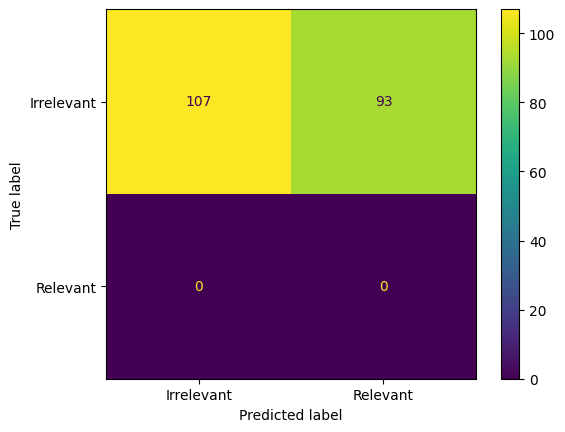

In [10]:

#! on fastfit/modeling.py, line 838, inserting **kwargs
#! it's easier than getting the tokenizer to stop outputting
#! extra info like token_type_ids

predicted_data = classifier.evaluate(
    test_dataset,
    metrics=[
        "accuracy",
        "precision",
        "classification-report",
        "specificity",
        "confusion-matrix-mpl",
    ],
    aggregate="majority",
    batch_size=48,
)

In [11]:
potential = predicted_data[predicted_data["predictions"] == "relevant"]
potential = potential.sort_values(by="score-lv1", ascending=False)


In [12]:
potential = potential[potential['text'].apply(lambda x: x!='No summary for this intervention.')]
potential = potential[potential['score-lv1'].apply(lambda x: x>=0.95)].reset_index(drop=True)

In [13]:
potential

,url,text,relevance,multiclasses,score,prediction,predictions,score-lv1
0,https://wsobirds.org/images/pdfs/BeyondBirdFee...,BEYOND THE BIRD FEEDER: Creating a Bird-Friend...,irrelevant,[],0.886178,relevant,relevant,0.999999
1,https://yearofthesalmon.org/wp-content/uploads...,Potential factors influencing variation in fre...,irrelevant,[],0.246988,irrelevant,relevant,0.999997
2,https://zooreach.org/downloads/Education_pkt_c...,"Freshwater Turtles, tortoises and terrapins Pa...",irrelevant,[],0.189166,irrelevant,relevant,0.999898
3,https://www.wyomingwildsheep.org/wp-content/up...,CONSERVATION VISION 2025 Why Wild Sheep? Wild ...,irrelevant,[],0.233056,irrelevant,relevant,0.999887
4,https://wtip.org/wp-content/uploads/2022/02/20...,"Wild Bee Surveys in Minnesota February, 2019 O...",irrelevant,[],0.358882,irrelevant,relevant,0.999875
...,...,...,...,...,...,...,...,...
78,https://files.worldwildlife.org/wwfcmsprod/fil...,NEPAL CONNECTING CORRIDORS TERAI ARC LANDSCAPE...,irrelevant,[],0.436584,irrelevant,relevant,0.954129
79,https://www.wyomingmining.org/wp-content/uploa...,Reclamation Challenges/Progress in the Four Co...,irrelevant,[],0.196303,irrelevant,relevant,0.952725
80,https://yearofthesalmon.org/wp-content/uploads...,Pink Salmon in the North American Arctic th IY...,irrelevant,[],0.296485,irrelevant,relevant,0.952076
81,https://zooreach.org/downloads/ZOO_CAMP_PHVA_r...,Conservation Assessment and Management Plan (C...,irrelevant,[],0.196773,irrelevant,relevant,0.951790


In [14]:
# get max min range of score
max_score = potential['score-lv1'].max()
min_score = potential['score-lv1'].min()
print(f"Max score: {max_score}")
print(f"Min score: {min_score}")



Max score: 0.9999989425694501
Min score: 0.9505292897423109


In [15]:
with pd.option_context('display.max_colwidth', 400):
    display(potential.head(10))

,url,text,relevance,multiclasses,score,prediction,predictions,score-lv1
0,https://wsobirds.org/images/pdfs/BeyondBirdFeederBookletFINAL.compressed.pdf,"BEYOND THE BIRD FEEDER: Creating a Bird-Friendly Yard with Native Wisconsin Plants i a m l o h t r a B k c a J By MARIETTE NOWAK for the Wisconsin Society for Ornithology, Inc. ver millions of years, birds and plants have Odeveloped mutually beneficial relationships. Birds help pollinate plants, disperse their seeds, and eat the insects that can ravage them. To entice the help of birds, plants...",irrelevant,[],0.886178,relevant,relevant,0.999999
1,https://yearofthesalmon.org/wp-content/uploads/2022/12/63-Potential-factors-influencing-variation-David_Scott.pdf,"Potential factors influencing variation in freshwater and estuarine growth rates of juvenile Chinook salmon in the Fraser River, B.C. David Scott, Misty MacDuffee, Lia Chalifour, Scott G. Hinch th IYS Symposium October 5 , 2022 Acknowledgments Raincoast Conserva.on Founda.on Misty MacDuﬀee and the rest of the team Fisheries and Oceans Canada Murray Manson, Eric Rondeau, Terry Beacham, Suzanne ...",irrelevant,[],0.246988,irrelevant,relevant,0.999997
2,https://zooreach.org/downloads/Education_pkt_catalogue/Freshwater%20Turtles%20Tortoises%20and%20terrapins.pdf,"Freshwater Turtles, tortoises and terrapins Packet consists of a Cover Foldout    Booklet Rakhi (wrist band) Mask Sticker Poster How do we differentiate a turtle from a tortoise? What do they eat? What are the different size, shape and colour of these creatures? Are these reptiles linked to our life? This packet has easy to learn materials to understand basics of these animals.",irrelevant,[],0.189166,irrelevant,relevant,0.999898
3,https://www.wyomingwildsheep.org/wp-content/uploads/2022/02/CV2025_V1.pdf,"CONSERVATION VISION 2025 Why Wild Sheep? Wild mountain sheep are special. To the hunter-conservationist community and other peoples the world over, the sight of a wild sheep represents a living rarity among our grand mountain ranges, places that epitomize the allure of wilderness, and thefreedom and fortitude these last vestiges offer. For many, just knowing they still exist in healthy conditi...",irrelevant,[],0.233056,irrelevant,relevant,0.999887
4,https://wtip.org/wp-content/uploads/2022/02/2019-bee-project-handout.pdf,"Wild Bee Surveys in Minnesota February, 2019 Our knowledge of wild bees Wild bees are vital components of Minnesota’s ecosystems by providing essential ecosystem services such as pollination. Although our knowledge of the diversity and distribution of Minnesota’s bees is improving, large gaps still exist. Laying the foundation for bee research Minnesota has an engaged and growing community of ...",irrelevant,[],0.358882,irrelevant,relevant,0.999875
5,https://www.xerces.org/sites/default/files/publications/24-004_Rethinking%20Weed%20Management%20at%20Home.pdf,PROTECTING POLLINATORS FROM HERBICIDES Rethinking Weed Management at Home Herbicide use can negatively affect pollinators and other beneficial insects and remove flowering plants in the landscape. Allowing some “wildness” in some or all of your yard and managing unwanted plants without chemicals can provide a variety of ecological benefits. What does it mean to pollinators that herbicides are ...,irrelevant,[],0.312299,irrelevant,relevant,0.999763
6,http://xerces.org/sites/default/files/publications/18-014.pdf,Nesting & Overwintering Habitat FOR POLLINATORS & OTHER BENEFICIAL INSECTS STEPS TO CREATE NESTING & OVERWINTING HABITAT: P Save the stems œ Leave the leaves Z Redefine the “perfect” lawn Ŏ Rethink how you use mulch Œ Save a snag and “plant” a log ő Build a brush pile ō Build a rock pile or rock wall C Provide a safe water source ò Install a habitat sign Figure 1: By selecting native plants an...,irrelevant,[],0.465836,irrelevant,relevant,0.999605
7,https://yearofthesalmon.org/wp-content/uploads/2022/12/33-Supplementary-stocking-selects-Ingerid_Hagen.pdf,"Supplementary stocking s